# Binary Counter Task Analysis

This notebook analyzes a MultiTimescaleRNN trained on the hierarchical binary counter task.

**Contents:**
1. Load trained model
2. Training & validation loss curves
3. Ground truth vs. predictions visualization
4. 3D PCA of hidden state activations
5. Learned timescale distribution

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import json
import yaml
from pathlib import Path

from rnns.multitimescale_rnn import MultiTimescaleRNN
from datamodules.binary_counter import HierarchicalCounterDataModule

import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Load Trained Model


In [3]:
import os
# Set the path to your trained model directory
MODEL_DIR = Path("/home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260112_025835")

print(os.path.exists(MODEL_DIR))

True


In [4]:
# Load config
config_files = list(MODEL_DIR.glob("config_seed*.yaml"))
if not config_files:
    raise FileNotFoundError(f"No config file found in {MODEL_DIR}")
    
with open(config_files[0]) as f:
    config = yaml.safe_load(f)

print("Task:", config.get("task", "path_integration"))
print("Config:")
for key in ['n_levels', 'base_flip_prob', 'noise_std', 'num_time_steps', 'hidden_size', 'activation', 'learn_timescales']:
    if key in config:
        print(f"  {key}: {config[key]}")

Task: binary_counter
Config:
  n_levels: 3
  base_flip_prob: 0.1
  noise_std: 0.0
  num_time_steps: 500
  hidden_size: 256
  activation: ReLU
  learn_timescales: True


In [5]:
# Load model
model_files = list(MODEL_DIR.glob("final_model_seed*.pth"))
if not model_files:
    raise FileNotFoundError(f"No model file found in {MODEL_DIR}")

# Reconstruct model architecture
model = MultiTimescaleRNN(
    input_size=config.get("input_size", 1),  # Binary counter has input_size=1 by default
    hidden_size=config["hidden_size"],
    output_size=config["n_levels"],  # Output is n_levels for binary counter
    dt=config["dt"],
    activation=getattr(nn, config["activation"]),
    learn_timescales=config["learn_timescales"],
    init_timescale=config.get("init_timescale"),
    normalize_hidden=config.get("normalize_hidden", False),
    zero_diag_wrec=config.get("zero_diag_wrec", True),
)

# Load weights
state_dict = torch.load(model_files[0], map_location="cpu", weights_only=True)
model.load_state_dict(state_dict)
model.eval()

print(f"Model loaded from {model_files[0]}")
print(model)

Timescales are LEARNABLE (uniform init at τ=0.5s)
Model loaded from /home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260112_025835/final_model_seed0.pth
MultiTimescaleRNN(
  (rnn_step): MultiTimescaleRNNStep(
    (activation): ReLU()
    (W_in): Linear(in_features=1, out_features=256, bias=True)
    (W_rec): Linear(in_features=256, out_features=256, bias=True)
  )
  (W_out): Linear(in_features=256, out_features=3, bias=False)
  (W_h_init): Linear(in_features=3, out_features=256, bias=False)
)


## 2. Training & Validation Loss vs Epoch


In [6]:
# Load loss history
loss_file = MODEL_DIR / "loss_history.json"

if loss_file.exists():
    with open(loss_file) as f:
        loss_history = json.load(f)
    
    epochs = loss_history.get("epochs", list(range(len(loss_history.get("train_loss", [])))))
    train_loss = loss_history.get("train_loss", [])
    val_loss = loss_history.get("val_loss", [])
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    ax.plot(epochs, train_loss, label="Train Loss", linewidth=2)
    ax.plot(epochs, val_loss, label="Validation Loss", linewidth=2)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("BCE Loss")
    ax.set_title("Training & Validation Loss")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale("log")
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final train loss: {train_loss[-1]:.4f}")
    print(f"Final val loss: {val_loss[-1]:.4f}")
else:
    print(f"Loss history file not found at {loss_file}")
    print("Available files:", list(MODEL_DIR.glob("*")))

Loss history file not found at /home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260112_025835/loss_history.json
Available files: [PosixPath('/home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260112_025835/config_seed0.yaml'), PosixPath('/home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260112_025835/timescale_history.json'), PosixPath('/home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260112_025835/checkpoints'), PosixPath('/home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260112_025835/gradient_statistics_weight_matrices.json'), PosixPath('/home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260112_025835/gradient_statistics.json'), PosixPath('/home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260112_025835/training_losses.json'), PosixPath('/home/facosta/timescales/timescales/logs/single_runs/multitimescale_20260112_025835/gradient_statistics.png'),

## 3. Ground Truth vs Predictions Visualization


In [7]:
# Create datamodule for generating test trajectories
dm = HierarchicalCounterDataModule(
    n_levels=config["n_levels"],
    base_flip_prob=config["base_flip_prob"],
    noise_std=config.get("noise_std", 0.1),
    num_time_steps=config["num_time_steps"],
    num_trajectories=100,  # Small number for visualization
    batch_size=16,
    num_workers=0,
)
dm.setup()

print(f"Theoretical timescales (steps): {dm.theoretical_timescales}")

Hierarchical Counter Task:
  Levels: 3
  Base flip probability: 0.1
  Theoretical timescales (in steps): [10. 20. 40.]
Dataset created: 80 train, 20 val trajectories
Theoretical timescales (steps): [10. 20. 40.]


In [8]:
# Get a batch of test data
batch = next(iter(dm.val_dataloader()))
inputs, states, targets = batch

print(f"Inputs shape: {inputs.shape}")
print(f"Targets shape: {targets.shape}")

# Run model on test data
with torch.no_grad():
    hidden_states, outputs = model(inputs, init_context=None)
    predictions = torch.sigmoid(outputs)  # Convert logits to probabilities

print(f"Hidden states shape: {hidden_states.shape}")
print(f"Outputs shape: {outputs.shape}")

Inputs shape: torch.Size([16, 500, 1])
Targets shape: torch.Size([16, 500, 3])
Hidden states shape: torch.Size([16, 500, 256])
Outputs shape: torch.Size([16, 500, 3])


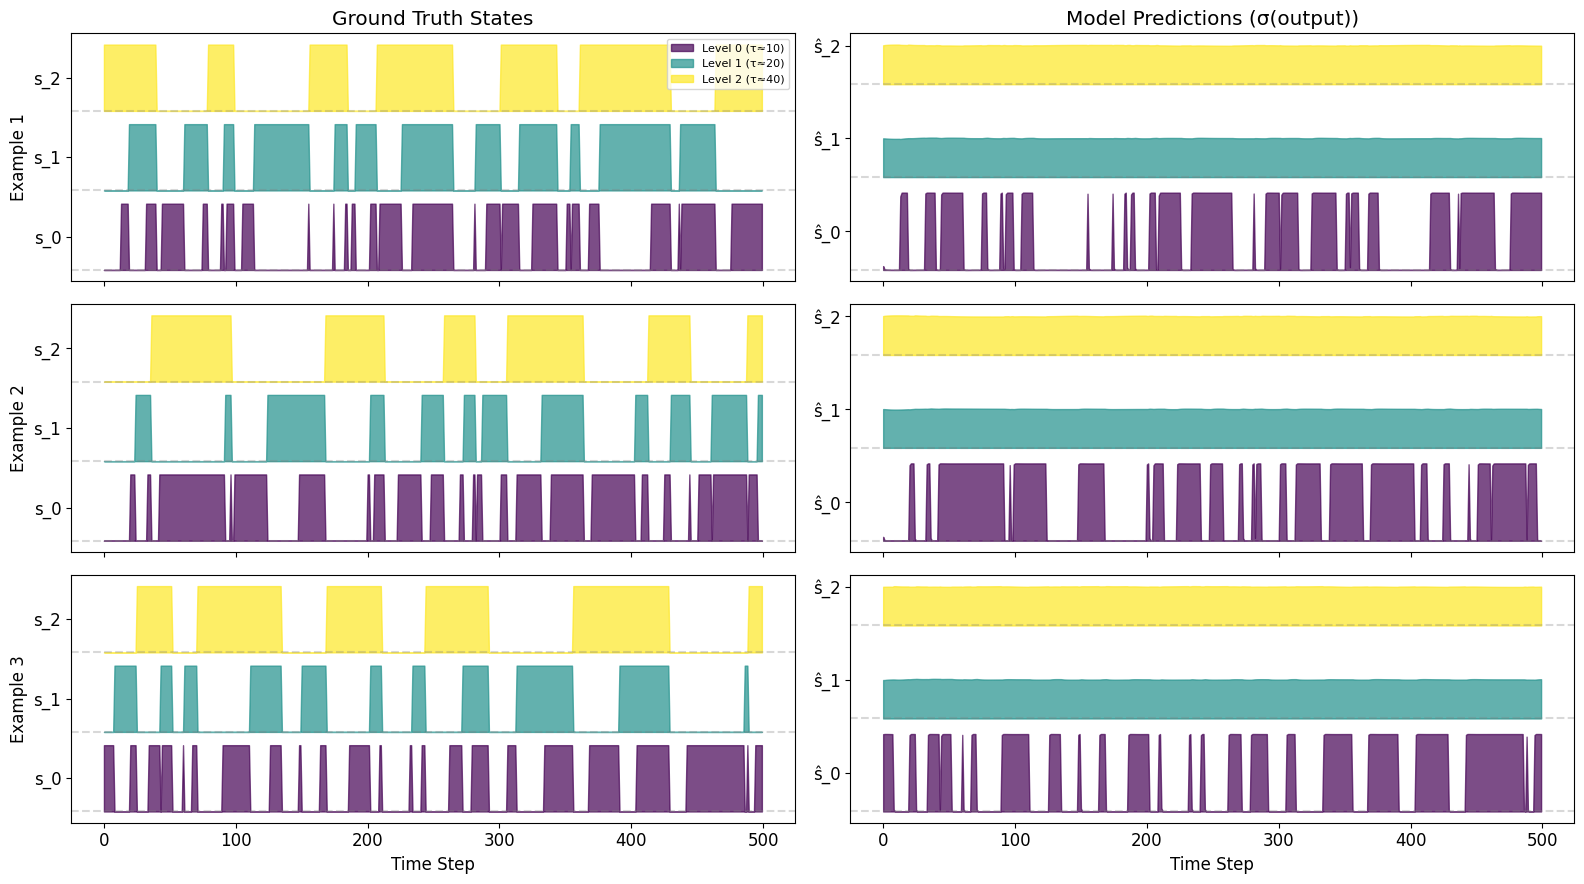

In [9]:
# Visualize ground truth vs predictions for a few example trajectories
n_examples = 3
n_levels = config["n_levels"]

fig, axes = plt.subplots(n_examples, 2, figsize=(16, 3 * n_examples), sharex=True)

colors = plt.cm.viridis(np.linspace(0, 1, n_levels))

for i in range(n_examples):
    # Left: Ground truth
    ax_gt = axes[i, 0]
    for level in range(n_levels):
        offset = level * 1.2  # Vertical offset for stacking
        ax_gt.fill_between(
            range(targets.shape[1]),
            offset,
            offset + targets[i, :, level].numpy(),
            alpha=0.7,
            color=colors[level],
            label=f"Level {level} (τ≈{dm.theoretical_timescales[level]:.0f})"
        )
        ax_gt.axhline(y=offset, color='gray', linestyle='--', alpha=0.3)
    
    ax_gt.set_ylabel(f"Example {i+1}")
    ax_gt.set_yticks([level * 1.2 + 0.5 for level in range(n_levels)])
    ax_gt.set_yticklabels([f"s_{level}" for level in range(n_levels)])
    if i == 0:
        ax_gt.set_title("Ground Truth States")
        ax_gt.legend(loc='upper right', fontsize=8)
    
    # Right: Predictions
    ax_pred = axes[i, 1]
    for level in range(n_levels):
        offset = level * 1.2
        ax_pred.fill_between(
            range(predictions.shape[1]),
            offset,
            offset + predictions[i, :, level].numpy(),
            alpha=0.7,
            color=colors[level],
        )
        ax_pred.axhline(y=offset, color='gray', linestyle='--', alpha=0.3)
    
    ax_pred.set_yticks([level * 1.2 + 0.5 for level in range(n_levels)])
    ax_pred.set_yticklabels([f"ŝ_{level}" for level in range(n_levels)])
    if i == 0:
        ax_pred.set_title("Model Predictions (σ(output))")

axes[-1, 0].set_xlabel("Time Step")
axes[-1, 1].set_xlabel("Time Step")

plt.tight_layout()
plt.savefig(MODEL_DIR / "ground_truth_vs_predictions.png", dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Compute per-level accuracy
with torch.no_grad():
    binary_preds = (predictions > 0.5).float()
    
    # Per-level accuracy
    for level in range(n_levels):
        acc = (binary_preds[:, :, level] == targets[:, :, level]).float().mean()
        print(f"Level {level} (τ≈{dm.theoretical_timescales[level]:.0f}): {acc:.4f} accuracy")
    
    # Overall accuracy
    overall_acc = (binary_preds == targets).float().mean()
    print(f"\nOverall accuracy: {overall_acc:.4f}")

Level 0 (τ≈10): 1.0000 accuracy
Level 1 (τ≈20): 0.5089 accuracy
Level 2 (τ≈40): 0.4781 accuracy

Overall accuracy: 0.6623


## 4. 3D PCA of Hidden State Activations


In [11]:
# Use more trajectories for PCA
n_trajectories_pca = 10

with torch.no_grad():
    hidden_states_pca, _ = model(inputs[:n_trajectories_pca], init_context=None)

# Reshape: [n_traj, T, hidden] -> [n_traj * T, hidden]
n_traj, T, hidden_size = hidden_states_pca.shape
hidden_flat = hidden_states_pca.reshape(-1, hidden_size).numpy()

print(f"Hidden states shape for PCA: {hidden_flat.shape}")

# Fit PCA
pca = PCA(n_components=3)
hidden_pca = pca.fit_transform(hidden_flat)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")

Hidden states shape for PCA: (5000, 256)
Explained variance ratio: [0.6578242  0.28217894 0.04824736]
Total explained variance: 98.83%


In [12]:
# Reshape back to [n_traj, T, 3]
hidden_pca_reshaped = hidden_pca.reshape(n_traj, T, 3)

# Interactive 3D plot colored by time
fig = go.Figure()

for traj_idx in range(n_traj):
    traj_data = hidden_pca_reshaped[traj_idx]
    
    fig.add_trace(go.Scatter3d(
        x=traj_data[:, 0],
        y=traj_data[:, 1],
        z=traj_data[:, 2],
        mode='lines+markers',
        marker=dict(
            size=3,
            color=np.arange(T),
            colorscale='Viridis',
            showscale=(traj_idx == 0),
            colorbar=dict(title="Time Step") if traj_idx == 0 else None,
        ),
        line=dict(width=2, color=f'rgba({50 + traj_idx*20}, {100 + traj_idx*10}, {200 - traj_idx*15}, 0.5)'),
        name=f'Trajectory {traj_idx}',
        hovertemplate=f'Traj {traj_idx}<br>PC1: %{{x:.2f}}<br>PC2: %{{y:.2f}}<br>PC3: %{{z:.2f}}<br>Time: %{{marker.color}}<extra></extra>'
    ))

fig.update_layout(
    title=f'3D PCA of Hidden States ({pca.explained_variance_ratio_.sum():.1%} variance explained)',
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]:.1%})',
    ),
    width=900,
    height=700,
    showlegend=True,
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Alternative: Color by the slowest level state (s_{K-1})
all_pc1 = hidden_pca_reshaped[:, :, 0].flatten()
all_pc2 = hidden_pca_reshaped[:, :, 1].flatten()
all_pc3 = hidden_pca_reshaped[:, :, 2].flatten()
all_states = targets[:n_traj, :, -1].numpy().flatten()

fig2 = go.Figure()

fig2.add_trace(go.Scatter3d(
    x=all_pc1,
    y=all_pc2,
    z=all_pc3,
    mode='markers',
    marker=dict(
        size=3,
        color=all_states,
        colorscale=[[0, 'blue'], [1, 'red']],
        showscale=True,
        colorbar=dict(title=f"s_{n_levels-1}"),
    ),
    hovertemplate=f'PC1: %{{x:.2f}}<br>PC2: %{{y:.2f}}<br>PC3: %{{z:.2f}}<br>s_{n_levels-1}: %{{marker.color}}<extra></extra>'
))

fig2.update_layout(
    title=f'3D PCA Colored by Slowest Level State (s_{n_levels-1})',
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]:.1%})',
    ),
    width=900,
    height=700,
)

fig2.show()


## 5. Learned Timescale Distribution

In [16]:
# Get learned timescales
if model.learn_timescales:
    timescales = model.rnn_step.current_timescales.detach().numpy()
    alphas = model.rnn_step.current_alphas.detach().numpy()
    
    print(f"Timescale stats:")
    print(f"  Min: {timescales.min():.4f} s")
    print(f"  Max: {timescales.max():.4f} s")
    print(f"  Mean: {timescales.mean():.4f} s")
    print(f"  Std: {timescales.std():.4f} s")
else:
    timescales = model.rnn_step.timescales.numpy()
    print("Timescales are fixed (not learned)")


Timescale stats:
  Min: 0.0693 s
  Max: 0.5141 s
  Mean: 0.2841 s
  Std: 0.1687 s


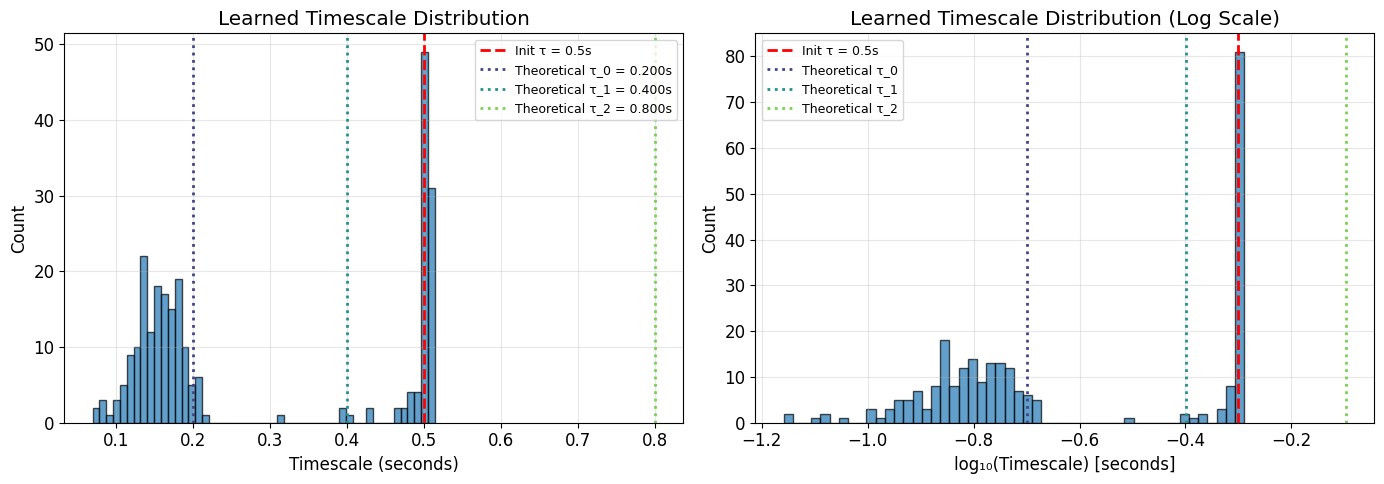

In [17]:
# Plot timescale histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Convert theoretical timescales from steps to seconds
dt = config["dt"]
theoretical_tau_seconds = dm.theoretical_timescales * dt

# Histogram of timescales (in seconds)
ax1 = axes[0]
ax1.hist(timescales, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(x=config.get("init_timescale", 0.5), color='red', linestyle='--', 
            label=f"Init τ = {config.get('init_timescale', 0.5)}s", linewidth=2)

# Add vertical lines for theoretical timescales
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(theoretical_tau_seconds)))
for i, (tau, c) in enumerate(zip(theoretical_tau_seconds, colors)):
    ax1.axvline(x=tau, color=c, linestyle=':', linewidth=2,
                label=f"Theoretical τ_{i} = {tau:.3f}s")

ax1.set_xlabel("Timescale (seconds)")
ax1.set_ylabel("Count")
ax1.set_title("Learned Timescale Distribution")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Log-scale histogram
ax2 = axes[1]
ax2.hist(np.log10(timescales), bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=np.log10(config.get("init_timescale", 0.5)), color='red', linestyle='--', 
            label=f"Init τ = {config.get('init_timescale', 0.5)}s", linewidth=2)

for i, (tau, c) in enumerate(zip(theoretical_tau_seconds, colors)):
    ax2.axvline(x=np.log10(tau), color=c, linestyle=':', linewidth=2,
                label=f"Theoretical τ_{i}")

ax2.set_xlabel("log₁₀(Timescale) [seconds]")
ax2.set_ylabel("Count")
ax2.set_title("Learned Timescale Distribution (Log Scale)")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / "learned_timescales.png", dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# Compare theoretical vs learned timescale coverage
print("\nTimescale Comparison:")
print(f"{'Level':<8} {'Theoretical (steps)':<20} {'Theoretical (s)':<18} {'Neurons in [τ/2, 2τ]':<20}")
print("-" * 70)

for i, (tau_steps, tau_s) in enumerate(zip(dm.theoretical_timescales, theoretical_tau_seconds)):
    # Find neurons with timescales closest to this theoretical value (within factor of 2)
    in_range = (timescales > tau_s / 2) & (timescales < tau_s * 2)
    n_in_range = in_range.sum()
    
    print(f"s_{i:<6} {tau_steps:<20.0f} {tau_s:<18.4f} {n_in_range}")


Timescale Comparison:
Level    Theoretical (steps)  Theoretical (s)    Neurons in [τ/2, 2τ]
----------------------------------------------------------------------
s_0      10                   0.2000             154
s_1      20                   0.4000             106
s_2      40                   0.8000             95


## Summary

In [19]:
print("=" * 60)
print("BINARY COUNTER ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nModel: {MODEL_DIR.name}")
print(f"Hidden size: {config['hidden_size']}")
print(f"Number of levels: {config['n_levels']}")
print(f"Base flip probability: {config['base_flip_prob']}")
print(f"\nTheoretical timescales (steps): {dm.theoretical_timescales}")
print(f"Theoretical timescales (seconds): {theoretical_tau_seconds}")
print(f"\nLearned timescale range: [{timescales.min():.4f}, {timescales.max():.4f}] s")
print(f"Learned timescale mean ± std: {timescales.mean():.4f} ± {timescales.std():.4f} s")
print("=" * 60)

BINARY COUNTER ANALYSIS SUMMARY

Model: multitimescale_20260112_025835
Hidden size: 256
Number of levels: 3
Base flip probability: 0.1

Theoretical timescales (steps): [10. 20. 40.]
Theoretical timescales (seconds): [0.2 0.4 0.8]

Learned timescale range: [0.0693, 0.5141] s
Learned timescale mean ± std: 0.2841 ± 0.1687 s
